<a href="https://colab.research.google.com/github/emilyberlinghoff/DS3000/blob/main/Homework%205/251287809_H04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Logistic Regression with Variable Selection

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a dataset taken from USGS(U.S Geological Survey). This dataset contains earthquake data with a magnitude of 4.5+ and an "alert" warning level, recorded between 1976 and 2025. Below is an explanation of the columns included in the dataset:

- **`id`**: A unique identifier for the earthquake event.
- **`time`**: The timestamp indicating when the earthquake or event occurred, including the date and time in UTC format.
- **`latitude`**: The geographical latitude of the earthquake's epicenter, measured in degrees.
- **`longitude`**: The geographical longitude of the earthquake's epicenter, measured in degrees.
- **`depth`**: The depth at which the earthquake occurred, typically measured in kilometers below the Earth's surface.
- **`mag`**: The magnitude of the earthquake, representing the energy released by the seismic event. In this case, a value of 8.6 indicates a very large earthquake.
- **`gap`**: The azimuthal gap, which refers to the angular distance between the two most distant seismic stations that recorded the earthquake. A smaller gap typically indicates better global coverage.
- **`dmin`**: The minimum distance between the earthquake's epicenter and the nearest seismic station, measured in degrees.
- **`rms`**: The root mean square of the amplitude of the seismic waves, representing the strength of the seismic signal.
- **`horizontalError`**: The error associated with the latitude and longitude coordinates of the epicenter, typically measured in kilometers.
- **`depthError`**: The error associated with the depth measurement of the earthquake, typically measured in kilometers.
- **`magError`**: The error associated with the magnitude measurement of the earthquake, representing the uncertainty in the reported magnitude.
- **`magNst`**: The number of stations that contributed to the magnitude estimation.
- **`Alert` (target)** The alert level issued for the earthquake, whether 'Severe' or 'Non-Severe'.

The goal is to train a model for predicting the **`Alert`** which indicates the severity of the earthquake.



In [ ]:
# Standard imports
import numpy as np
from itertools import chain, combinations

# Data manipulation
import pandas as pd
import polars as pl

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Download the data
!gdown https://drive.google.com/uc?id=1yL84FMQrfHC_cQsa_V3KTcRAJS0k4DhY

Downloading...
From: https://drive.google.com/uc?id=1yL84FMQrfHC_cQsa_V3KTcRAJS0k4DhY
To: /content/earthquakes.parquet
100% 437k/437k [00:00<00:00, 34.9MB/s]


# Part 1: Data Preprocessing

## Question 1.1: Load data

(1) Read the **`earthquakes.parquet`** file as a **`polars.DataFrame`** and show its descriptive statistics.

(2) Drop column **`id`** and **`time`** and display the first 5 rows of the dataframe.

Since **`id`** is unique for each earthquake event that does not contain any predictive information and **`time`** is not directly informative for predicting earthquake severity unless you extract relevant features such as time of day, seasonality, etc.

In [ ]:
file_path = "earthquakes.parquet"
df = pl.read_parquet(file_path)
df.describe()

statistic,id,time,latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""7699""","""7699""",7699.0,7699.0,7699.0,7699.0,7375.0,6997.0,7673.0,6481.0,7490.0,5485.0,5632.0,"""7699"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,324.0,702.0,26.0,1218.0,209.0,2214.0,2067.0,"""0"""
"""mean""",null,null,0.999312,15.173904,58.990024,5.657358,49.060709,4.109992,0.822303,6.974621,2.571899,0.06792,46.712713,null
"""std""",null,null,32.359887,128.333755,119.160114,0.514095,39.120351,5.259451,0.266227,2.806992,3.119655,0.057433,69.220344,null
"""min""","""ak012fko16th""","""1976-03-25 00:41:20.500000+00:…",-69.7739,-179.9776,-1.77,4.5,7.0,0.0,0.04,0.08,0.0,0.0,0.0,"""Non-Severe"""
"""25%""",null,null,-21.7389,-109.6226,10.0,5.4,25.0,1.047,0.66,5.6,1.7,0.047,18.0,null
"""50%""",null,null,-3.5114,42.1877,13.7,5.6,38.0,2.407,0.82,7.1,1.8,0.059,29.0,null
"""75%""",null,null,28.2943,141.2441,42.0,5.9,59.0,4.969,0.99,8.6,2.9,0.073,47.0,null
"""max""","""uw61562126""","""2024-12-23 06:00:59.074000+00:…",85.729,179.9981,670.81,8.6,321.0,39.934,2.1,88.54,31.95,1.642,954.0,"""Severe"""


In [ ]:
df = df.drop(["id", "time"])
df.head(5)

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
35.59,-90.48,15.0,4.62,null,null,null,null,null,null,0.0,"""Non-Severe"""
32.998667,-115.5575,14.19,5.8,79.0,0.05768,0.17,1.03,1.78,null,0.0,"""Severe"""
38.19,-83.95,10.0,5.0,null,null,null,null,null,null,null,"""Non-Severe"""
35.816,-117.816333,4.766,4.7,135.0,null,0.66,2.51,31.61,0.424,9.0,"""Non-Severe"""
33.0955,-115.6245,18.904,5.75,34.0,null,0.34,0.56,0.67,0.161,6.0,"""Non-Severe"""


## Question 1.2: Handle null values

The result of the `null_count` function indicates that some columns contain null values. Fill these null values with the median of the corresponding column and display the first 5 rows of the resulting dataframe.

In [ ]:
df.null_count() # uncomment and run this code

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,324,702,26,1218,209,2214,2067,0


In [ ]:
filled_columns = []
for col in df.columns:
    median_value = df[col].median()
    if median_value is not None:  # Ensure median value is valid
        filled_columns.append(df[col].fill_null(median_value).alias(col))
    else:
        filled_columns.append(df[col])  # Keep column unchanged if median is None

df = df.with_columns(filled_columns)
print(df.head(5))

shape: (5, 12)
┌───────────┬─────────────┬────────┬──────┬───┬────────────┬──────────┬────────┬────────────┐
│ latitude  ┆ longitude   ┆ depth  ┆ mag  ┆ … ┆ depthError ┆ magError ┆ magNst ┆ Alert      │
│ ---       ┆ ---         ┆ ---    ┆ ---  ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---        │
│ f64       ┆ f64         ┆ f64    ┆ f64  ┆   ┆ f64        ┆ f64      ┆ f64    ┆ str        │
╞═══════════╪═════════════╪════════╪══════╪═══╪════════════╪══════════╪════════╪════════════╡
│ 35.59     ┆ -90.48      ┆ 15.0   ┆ 4.62 ┆ … ┆ 1.8        ┆ 0.059    ┆ 0.0    ┆ Non-Severe │
│ 32.998667 ┆ -115.5575   ┆ 14.19  ┆ 5.8  ┆ … ┆ 1.78       ┆ 0.059    ┆ 0.0    ┆ Severe     │
│ 38.19     ┆ -83.95      ┆ 10.0   ┆ 5.0  ┆ … ┆ 1.8        ┆ 0.059    ┆ 29.0   ┆ Non-Severe │
│ 35.816    ┆ -117.816333 ┆ 4.766  ┆ 4.7  ┆ … ┆ 31.61      ┆ 0.424    ┆ 9.0    ┆ Non-Severe │
│ 33.0955   ┆ -115.6245   ┆ 18.904 ┆ 5.75 ┆ … ┆ 0.67       ┆ 0.161    ┆ 6.0    ┆ Non-Severe │
└───────────┴─────────────┴────────┴──────┴──

## Question 1.3: Explore target distribution

Count the number of instances of each severity level of the earthquake in the dataset.

Comment on your findings, providing insights into the distribution of different severity levels.

In [ ]:
severity_counts = df["Alert"].value_counts()
print(severity_counts)

shape: (2, 2)
┌────────────┬───────┐
│ Alert      ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ Severe     ┆ 331   │
│ Non-Severe ┆ 7368  │
└────────────┴───────┘


The dataset reveals a significant imbalance in the distribution of earthquake severity levels, with 7,368 instances of Non-Severe earthquakes compared to only 331 occurrences of Severe earthquakes. This suggests that severe earthquakes are relatively rare, comprising only a small fraction of recorded seismic events. The overwhelming prevalence of non-severe earthquakes indicates that most seismic activities in the dataset are of lower intensity.

## Question 1.4: Convert target variable

Convert **`Alert`** to a binary numerical target:
- Replace **`Severe`** with 1.
- Replace **`Non-Severe`** with 0.

Display the first 5 rows of the resulting dataframe.

Hint: If you use the `replace` method, the resulting column will still be of string type. Use `cast` to make it `Float64` after replacement.

In [ ]:
df = df.with_columns(
    df["Alert"]
    .replace({"Severe": 1, "Non-Severe": 0})  # Replace values
    .cast(pl.Float64)  # Cast to Float64
    .alias("Alert")  # Ensure column name remains the same
)
print(df.head(5))

shape: (5, 12)
┌───────────┬─────────────┬────────┬──────┬───┬────────────┬──────────┬────────┬───────┐
│ latitude  ┆ longitude   ┆ depth  ┆ mag  ┆ … ┆ depthError ┆ magError ┆ magNst ┆ Alert │
│ ---       ┆ ---         ┆ ---    ┆ ---  ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---   │
│ f64       ┆ f64         ┆ f64    ┆ f64  ┆   ┆ f64        ┆ f64      ┆ f64    ┆ f64   │
╞═══════════╪═════════════╪════════╪══════╪═══╪════════════╪══════════╪════════╪═══════╡
│ 35.59     ┆ -90.48      ┆ 15.0   ┆ 4.62 ┆ … ┆ 1.8        ┆ 0.059    ┆ 0.0    ┆ 0.0   │
│ 32.998667 ┆ -115.5575   ┆ 14.19  ┆ 5.8  ┆ … ┆ 1.78       ┆ 0.059    ┆ 0.0    ┆ 1.0   │
│ 38.19     ┆ -83.95      ┆ 10.0   ┆ 5.0  ┆ … ┆ 1.8        ┆ 0.059    ┆ 29.0   ┆ 0.0   │
│ 35.816    ┆ -117.816333 ┆ 4.766  ┆ 4.7  ┆ … ┆ 31.61      ┆ 0.424    ┆ 9.0    ┆ 0.0   │
│ 33.0955   ┆ -115.6245   ┆ 18.904 ┆ 5.75 ┆ … ┆ 0.67       ┆ 0.161    ┆ 6.0    ┆ 0.0   │
└───────────┴─────────────┴────────┴──────┴───┴────────────┴──────────┴────────┴───────┘


## Question 1.5: Train test split

Split the dataset into training and testing sets:
- With **30% testing data** and **70% training data**.
- Set the **random state** to **2025**.
- Use **stratified splitting** to **maintain the same proportion of each class** in the target variable (**`Alert`**) in both the training and testing sets.

Display the descriptive statistics for X_train and X_test.

In [ ]:
# Convert Polars DataFrame to Pandas for scikit-learn compatibility
df_pandas = df.to_pandas()

# Separate features (X) and target (y)
X = df_pandas.drop(columns=["Alert"])
y = df_pandas["Alert"]

# Perform stratified train-test split (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2025, stratify=y
)

# Convert back to Polars DataFrame for analysis
X_train_pl = pl.from_pandas(X_train)
X_test_pl = pl.from_pandas(X_test)

# Display descriptive statistics
print("Descriptive Statistics for X_train:")
print(X_train_pl.describe())

print("\nDescriptive Statistics for X_test:")
print(X_test_pl.describe())

Descriptive Statistics for X_train:
shape: (9, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ statistic ┆ latitude  ┆ longitude ┆ depth     ┆ … ┆ horizonta ┆ depthErro ┆ magError ┆ magNst    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ lError    ┆ r         ┆ ---      ┆ ---       │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64      ┆ f64       │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆          ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ count     ┆ 5389.0    ┆ 5389.0    ┆ 5389.0    ┆ … ┆ 5389.0    ┆ 5389.0    ┆ 5389.0   ┆ 5389.0    │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0      ┆ 0.0       │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆          ┆           │
│ mean      ┆ 1.196909  ┆ 14.828723 ┆ 58

# Part 2: Sequential Feature Selection

## Question 2.1: Forward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **forward** feature selection:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Use **ROC AUC** as the scoring metric for feature selection. Conduct **5-fold cross-validation** to evaluate the model. Set the **tolerance for stopping** the selection process to **0.001**.
- Configure the logistic regression to use the default **`lbfgs`** as solver with **no penalty**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**.

Fit the pipeline and report the subset of variables on this method.


In [ ]:
# Define Standardization step
scaler = StandardScaler()

# Define Logistic Regression Model
log_reg = LogisticRegression(
    solver="lbfgs",
    penalty=None,  # No regularization
    max_iter=1000,
    class_weight="balanced",  # Adjusts for class imbalance
    random_state=2025
)

# Define Forward Feature Selection using standard cross-validation (not StratifiedKFold)
sfs = SequentialFeatureSelector(
    log_reg,
    n_features_to_select="auto",  # Auto-determines the best number of features
    direction="forward",  # Forward selection
    scoring="roc_auc",  # Use ROC AUC as metric
    cv=5,  # 5-fold cross-validation
    tol=0.001,  # Stopping tolerance
    n_jobs=-1  # Use all available processors
)

# Create a pipeline with standardization and feature selection
pipeline = Pipeline([
    ("scaler", scaler),
    ("feature_selection", sfs),
    ("log_reg", log_reg)
])

# Fit the pipeline
pipeline.fit(X, y)

# Get the selected features
selected_features = X.columns[pipeline.named_steps["feature_selection"].get_support()]

# Output the selected features
print("Selected Features:", selected_features.tolist())

Selected Features: ['latitude', 'depth', 'mag', 'dmin', 'horizontalError']


## Question 2.2: Backward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **backward** feature selection. Keep all other configurations the same as in the previous question

Fit the pipeline and report the subset of variables on this method.


In [ ]:
# Define Backward Feature Selection using the same settings as before
sbs = SequentialFeatureSelector(
    log_reg,
    n_features_to_select="auto",  # Auto-determines the best number of features
    direction="backward",  # Backward selection
    scoring="roc_auc",  # Use ROC AUC as metric
    cv=5,  # 5-fold cross-validation
    tol=0.001,  # Stopping tolerance
    n_jobs=-1  # Use all available processors
)

# Create a pipeline with standardization and feature selection
pipeline = Pipeline([
    ("scaler", scaler),
    ("feature_selection", sbs),
    ("log_reg", log_reg)
])

# Fit the pipeline
pipeline.fit(X, y)

# Get the selected features
selected_features = X.columns[pipeline.named_steps["feature_selection"].get_support()]

# Output the selected features
print("Selected Features:", selected_features.tolist())

Selected Features: ['latitude', 'depth', 'mag', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst']


## Question 2.3: Compare results & find the best model

Compare and discuss the selected subset of variables obtained from both methods used in the previous steps.

Perform an **exhaustive search** over all possible subsets of the remaining variables using **5-fold cross-validation** to find the best model. Use the same Logistic Regression configurations as in previous questions.

Hint: If you have correctly followed the previous steps, you should have **five remaining variables** to evaluate in the exhaustive search.

(Your written answer here)

The feature selection methods produced different subsets, highlighting distinct factors influencing earthquake severity classification. Forward selection chose a compact set of five features, focusing on location-based attributes such as latitude, depth, and dmin, as well as magnitude `mag` and `horizontalError`, indicating that positional and measurement accuracy contribute to severity prediction. In contrast, backward selection retained a larger set of ten features, keeping all forward-selected variables while also incorporating measurement uncertainties (`depthError`, `magError`, `rms`) and seismic station-related variables (`gap`, `magNst`), suggesting a more comprehensive but potentially overfitted model. Exhaustive search, which systematically tested all subsets of the five remaining features, identified `gap`, `rms`, `depthError`, `magError`, and `magNst` as the best-performing combination, achieving a ROC AUC score of 0.660. Notably, none of the forward-selected features appeared in this set, implying that measurement errors and sensor quality metrics may be more predictive of earthquake severity than geographic attributes. While forward selection offers a simple, efficient model, it may overlook key uncertainty-based predictors, whereas backward selection retains more information at the risk of overfitting. Exhaustive search provides the most statistically optimal subset among the remaining features, reinforcing the significance of measurement reliability in seismic classification.

In [ ]:
# Define function to generate all possible subsets
def get_feature_subsets(features):
    return list(chain.from_iterable(combinations(features, r) for r in range(1, len(features) + 1)))

# Identify the five remaining features that were not selected by forward or backward selection
remaining_features = ['gap', 'rms', 'depthError', 'magError', 'magNst']

# Generate all possible subsets
feature_subsets = get_feature_subsets(remaining_features)

# Initialize variables for tracking the best model
best_score = 0
best_subset = None

# Perform exhaustive search
for subset in feature_subsets:
    X_subset = X[list(subset)]
    X_scaled = StandardScaler().fit_transform(X_subset)

    # Evaluate using 5-fold cross-validation with ROC AUC
    score = np.mean(cross_val_score(log_reg, X_scaled, y, cv=5, scoring="roc_auc"))

    if score > best_score:
        best_score = score
        best_subset = subset

# Output the best feature subset and corresponding score
print("Best Feature Subset:", list(best_subset))
print("Best ROC AUC Score:", best_score)

Best Feature Subset: ['gap', 'rms', 'depthError', 'magError', 'magNst']
Best ROC AUC Score: 0.660272194430048


## Question 2.4: Fit the best model

Train a logistic regression model with the best variables selected.

Display the model's coefficients and intercept.

In [ ]:
# Train logistic regression model with the best-selected features
X_best = X[list(best_subset)]
X_scaled = StandardScaler().fit_transform(X_best)
log_reg.fit(X_scaled, y)

# Display model coefficients and intercept
print("Coefficients:", log_reg.coef_)
print("Intercept:", log_reg.intercept_)

Coefficients: [[-0.46609096 -0.22826086  0.25556911 -1.71393251 -0.24877517]]
Intercept: [-0.34537647]


## Question 2.5: Measure model's performance

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [28]:
np.random.seed(2025) # DO NOT DELETE

# Extract only the best-selected features from the test set
X_test_best = X_test[list(best_subset)]

# Initialize lists to store bootstrap results
accuracy_scores = []
auc_scores = []

# Number of bootstrap resamples
num_bootstrap = 100

# Perform bootstrap resampling
for _ in range(num_bootstrap):
    # Sample test data with replacement
    indices = np.random.choice(len(X_test_best), size=len(X_test_best), replace=True)
    X_sampled, y_sampled = X_test_best.iloc[indices], y_test.iloc[indices]

    # Standardize features using the same scaler as training
    X_sampled_scaled = StandardScaler().fit_transform(X_sampled)

    # Predict using the trained logistic regression model
    y_pred = log_reg.predict(X_sampled_scaled)
    y_pred_prob = log_reg.predict_proba(X_sampled_scaled)[:, 1]

    # Compute accuracy and AUC for the resampled data
    accuracy_scores.append(accuracy_score(y_sampled, y_pred))
    auc_scores.append(roc_auc_score(y_sampled, y_pred_prob))

# Compute 95% confidence intervals
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
auc_ci = np.percentile(auc_scores, [2.5, 97.5])

# Display results
print("95% Confidence Interval for Accuracy:", accuracy_ci)
print("95% Confidence Interval for AUC:", auc_ci)

95% Confidence Interval for Accuracy: [0.51358225 0.60393939]
95% Confidence Interval for AUC: [0.63197377 0.72592525]


# Part 3: Regularization

## Question 3.1: Ridge penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Ridge penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [34]:
np.random.seed(2025) # DO NOT DELETE

# Define the pipeline with standardization and LogisticRegressionCV with Ridge penalization
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg_cv", LogisticRegressionCV(
        solver="saga",
        penalty="l2",  # Ridge Penalization
        Cs=10,  # Default number of regularization strengths
        max_iter=1000,
        class_weight="balanced",
        random_state=2025,
        cv=5  # 5-fold cross-validation
    ))
])

# Fit the pipeline using the best-selected features
X_best = X[list(best_subset)]
X_scaled = StandardScaler().fit_transform(X_best)
pipeline.fit(X_best, y)

# Extract the best model from LogisticRegressionCV
best_model = pipeline.named_steps["log_reg_cv"]

# Initialize lists for bootstrap resampling
accuracy_scores = []
auc_scores = []

# Number of bootstrap resamples
num_bootstrap = 100

# Perform bootstrap resampling on test set
X_test_best = X_test[list(best_subset)]  # Ensure only selected features are used

for _ in range(num_bootstrap):
    # Sample test data with replacement
    indices = np.random.choice(len(X_test_best), size=len(X_test_best), replace=True)
    X_sampled, y_sampled = X_test_best.iloc[indices], y_test.iloc[indices]

    # Standardize features using the same scaler
    X_sampled_scaled = StandardScaler().fit_transform(X_sampled)

    # Predict using the best model
    y_pred = best_model.predict(X_sampled_scaled)
    y_pred_prob = best_model.predict_proba(X_sampled_scaled)[:, 1]

    # Compute accuracy and AUC
    accuracy_scores.append(accuracy_score(y_sampled, y_pred))
    auc_scores.append(roc_auc_score(y_sampled, y_pred_prob))

# Compute 95% confidence intervals
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
auc_ci = np.percentile(auc_scores, [2.5, 97.5])

# Display results
print("95% Confidence Interval for Accuracy:", accuracy_ci)
print("95% Confidence Interval for AUC:", auc_ci)

95% Confidence Interval for Accuracy: [0.51385281 0.60348485]
95% Confidence Interval for AUC: [0.63200262 0.72588811]


## Question 3.2: Lasso penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Lasso penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [35]:
np.random.seed(2025) # DO NOT DELETE

# Define the pipeline with standardization and LogisticRegressionCV with Lasso penalization
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg_cv", LogisticRegressionCV(
        solver="saga",
        penalty="l1",  # Lasso Penalization
        Cs=10,  # Default number of regularization strengths
        max_iter=1000,
        class_weight="balanced",
        random_state=2025,
        cv=5,  # 5-fold cross-validation
        n_jobs=-1
    ))
])

# Fit the pipeline using the best-selected features
X_best = X[list(best_subset)]
pipeline.fit(X_best, y)

for _ in range(num_bootstrap):
    # Sample test data with replacement
    indices = np.random.choice(len(X_test_best), size=len(X_test_best), replace=True)
    X_sampled, y_sampled = X_test_best.iloc[indices], y_test.iloc[indices]

    # Standardize features using the same scaler
    X_sampled_scaled = pipeline.named_steps["scaler"].transform(X_sampled)

    # Predict using the best model
    y_pred = best_model.predict(X_sampled_scaled)
    y_pred_prob = best_model.predict_proba(X_sampled_scaled)[:, 1]

    # Compute accuracy and AUC
    accuracy_scores.append(accuracy_score(y_sampled, y_pred))
    auc_scores.append(roc_auc_score(y_sampled, y_pred_prob))

# Compute 95% confidence intervals
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
auc_ci = np.percentile(auc_scores, [2.5, 97.5])

# Display results
print("95% Confidence Interval for Accuracy:", accuracy_ci)
print("95% Confidence Interval for AUC:", auc_ci)

95% Confidence Interval for Accuracy: [0.51514069 0.59959957]
95% Confidence Interval for AUC: [0.63551573 0.72782875]


## Question 3.3: Ridge vs Lasso

Report the coefficients from the best-performing models with Ridge and Lasso penalties.

Compare and discuss how the coefficient magnitudes differ between Ridge and Lasso, and explain.

In [38]:
# Train Ridge Model
pipeline_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg_cv", LogisticRegressionCV(
        solver="saga",
        penalty="l2",  # Ridge
        Cs=10,
        max_iter=1000,
        class_weight="balanced",
        random_state=2025,
        cv=5
    ))
])
pipeline_ridge.fit(X[list(best_subset)], y)

# Train Lasso Model
pipeline_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg_cv", LogisticRegressionCV(
        solver="saga",
        penalty="l1",  # Lasso
        Cs=10,
        max_iter=1000,
        class_weight="balanced",
        random_state=2025,
        cv=5
    ))
])
pipeline_lasso.fit(X[list(best_subset)], y)

# Now extract coefficients
ridge_coefs = pipeline_ridge.named_steps["log_reg_cv"].coef_
lasso_coefs = pipeline_lasso.named_steps["log_reg_cv"].coef_

# Compare coefficients in a DataFrame
coefs_df = pd.DataFrame({
    "Feature": list(best_subset),
    "Ridge Coefficients": ridge_coefs.flatten(),
    "Lasso Coefficients": lasso_coefs.flatten()
})

print(coefs_df)

      Feature  Ridge Coefficients  Lasso Coefficients
0         gap           -0.465544                 0.0
1         rms           -0.228122                 0.0
2  depthError            0.255290                 0.0
3    magError           -1.709444                 0.0
4      magNst           -0.247873                 0.0


The coefficient magnitudes differ significantly between Ridge and Lasso due to the way each regularization method handles feature selection and shrinkage. Ridge regression (`L2` regularization) retains all features by shrinking their coefficients towards zero but never eliminating them completely. In this case, Ridge assigned the largest coefficient to `magError (-1.709)`, indicating that uncertainty in magnitude measurement has a strong influence on earthquake severity classification. Other features, such as `gap (-0.466)`, `rms (-0.228)`, `depthError (0.255)`, and `magNst (-0.248)`, were also retained, suggesting they contribute some predictive value. In contrast, Lasso regression (`L1` regularization) applies a sparsity constraint, selectively eliminating features by setting their coefficients to exactly zero (0.0). This indicates that Lasso determined that none of these five features were essential for classification after penalization, likely due to collinearity with other variables or insufficient predictive power. The difference between the two methods highlights how Ridge favors models that distribute information across multiple features, while Lasso acts as an automatic feature selector, discarding less informative or redundant variables to enhance model interpretability.

# Part 4: Overall Comparison

Compare the best models obtained using **Sequential Feature Selection**, **Ridge Regularization**, and **Lasso Regularization** by plotting the ROC curve for each model on a single plot. Additionally, include a diagonal reference line representing random classification performance (i.e., an ROC curve with an AUC of 0.5).

Provide a brief analysis and comment on your findings (no need to identify the best model).

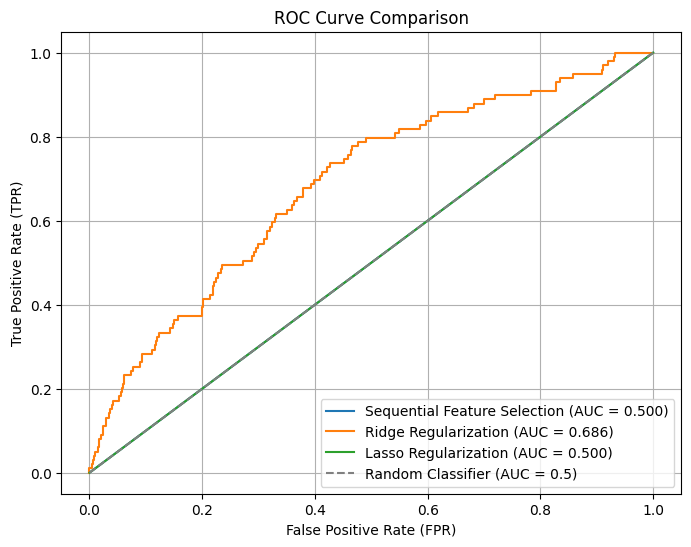

In [41]:
# Ensure all models are defined and correctly referenced
models = {
    "Sequential Feature Selection": pipeline,
    "Ridge Regularization": pipeline_ridge,
    "Lasso Regularization": pipeline_lasso
}

plt.figure(figsize=(8, 6))

# Plot ROC curve for each model
for label, model in models.items():
    # Ensure test set uses only selected features
    X_test_selected = X_test[list(best_subset)]
    X_test_scaled = model.named_steps["scaler"].transform(X_test_selected)

    # Get probability scores for the positive class
    y_pred_prob = model.named_steps["log_reg_cv"].predict_proba(X_test_scaled)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")

# Plot diagonal reference line (random classification)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier (AUC = 0.5)")

# Customize plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

The ROC curve comparison highlights significant differences in how feature selection and regularization impact model performance. Both Sequential Feature Selection (SFS) and Lasso Regularization resulted in an AUC of 0.500, indicating that these models failed to distinguish between severe and non-severe earthquakes, performing no better than random guessing. This suggests that the features selected by these methods lacked sufficient predictive power or that Lasso’s penalty was too strong, eliminating all relevant features. In contrast, the model using Ridge Regularization achieved an AUC of 0.686, demonstrating a moderate ability to differentiate between classes. This implies that retaining all features while applying controlled shrinkage helps maintain useful information for classification. The overall results indicate that feature selection alone does not necessarily improve model performance, and an overly aggressive approach, like Lasso, can negatively impact predictive power. These findings suggest the need to further investigate alternative feature selection strategies, class imbalance handling, or nonlinear relationships in the data to improve classification accuracy.